In [18]:
# Basic dependencies
import numpy as np
import pandas as pd
import math
import time
import os
import warnings

# Plotting dependencies
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable
from matplotlib import pyplot as plt

# Scientific computing
from scipy.stats import gaussian_kde, qmc
import numpy as np
from numpy import loadtxt
from matplotlib import pyplot as plt
from scipy import stats
from pathlib import Path
import re
from typing import Dict, List

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
####util
import numpy as np
from numpy import loadtxt
from matplotlib import pyplot as plt
from scipy import stats
#########
# PyTorch
import torch
from numpy import savetxt
# BoTorch - Core utilities
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.sampling import SobolQMCNormalSampler
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning

# BoTorch - Models
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from botorch.fit import fit_gpytorch_mll
from botorch import fit_gpytorch_mll

# BoTorch - Acquisition functions
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.acquisition.objective import GenericMCObjective, ConstrainedMCObjective
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.acquisition.multi_objective.predictive_entropy_search import qMultiObjectivePredictiveEntropySearch
from botorch.acquisition.multi_objective.max_value_entropy_search import qLowerBoundMultiObjectiveMaxValueEntropySearch
from botorch.acquisition.multi_objective.joint_entropy_search import qLowerBoundMultiObjectiveJointEntropySearch

# GPyTorch
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy import stats
# PyMOO
from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem, Problem as PymooProblem
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting, NonDominatedSorting as NDS
from pymoo.core.termination import NoTermination
from pymoo.termination import get_termination
from pymoo.core.population import Population
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.core.variable import Real
from pymoo.core.problem import Problem
from pymoo.util.dominator import Dominator

# JMetalPy
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
from jmetal.util.termination_criterion import StoppingByEvaluations, TerminationCriterion
from jmetal.util.aggregation_function import Tschebycheff
from jmetal.operator import PolynomialMutation, DifferentialEvolutionCrossover
from jmetal.algorithm.multiobjective.moead import Permutation
from jmetal.algorithm.multiobjective import MOEADIEpsilon

# Type hints
from typing import Optional
from torch import Tensor

# Configuration
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
torch.set_printoptions(precision=3)

tkwargs = {
    "dtype": torch.double,  # set as double to minimize zero error for cholesky decomposition error
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set tensors to GPU, if multiple GPUs please set cuda:x properly
}

# Warning filters
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Matplotlib inline and colormap setup
%matplotlib inline
cm = plt.cm.get_cmap('viridis')

# Plot styling
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Utility functions
def ci(y, N_TRIALS):
    """Calculate confidence interval"""
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

/tmp/ipykernel_6169/2270084960.py:131: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('viridis')


In [19]:
def optimize_qnehvi_nsga_uncons(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI + U-NSGA-III")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    # Before your trials loop
    all_sel_idx = []


    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_mll(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=None, # constraint on last n_constr col
            prune_baseline=True, cache_pending=True,eta=1e-3, fat=1e-3)  # options for improving qNEHVI, keep these on

        ##########
        
        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts if q candidates fail to show improvement
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )
              
        # we pick out the best points so far to form parents
        pareto_mask = is_non_dominated(train_obj)
        pareto_y = -train_obj[pareto_mask]
        pareto_x = train_x_gp[pareto_mask]
        

        algorithm = UNSGA3(pop_size=256,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
                           sampling=pareto_x.cpu().numpy(),
                           #crossover=SimulatedBinaryCrossover(eta=30, prob=1.0),
                           #mutation=PolynomialMutation(eta=20, prob=None),
                          )

        pymooproblem = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr, 
                      xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

        algorithm.setup(pymooproblem, termination=NoTermination())
        
        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", pareto_y.cpu().numpy())
        
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)

        # total pool of candidates for sorting
        candidates = torch.cat([qnehvi_x, nsga3_x])
        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        sorted_x = candidates.cpu().numpy()[np.argsort(acq_value_list)]
        
        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs)# take best BATCH_SIZE samples
        sorted_idx = np.argsort(acq_value_list)
        sel_idx = sorted_idx[-BATCH_SIZE:]
        X_sel = candidates[sel_idx]
        all_sel_idx.append(sel_idx)
        if verbose:
            print(f"Iteration {iteration} selected indices: {sel_idx}")
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        

        # computing HV of current candidate list
         # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj# take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, qnehvi_x, nsga3_x, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
            
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    t1 = time.time()
    timetotal = t1-t0
    print(f"Time taken in total: {timetotal:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy(), timetotal,all_sel_idx

In [20]:
def optimize_qnehvi_nsga(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI + U-NSGA-III")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    # Before your trials loop
    all_sel_idx = []


    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_mll(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True,eta=1e-3, fat=1e-3)  # options for improving qNEHVI, keep these on

        ##########
        
        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts if q candidates fail to show improvement
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )
              
        # we pick out the best points so far to form parents
        pareto_mask = is_non_dominated(train_obj)
        pareto_y = -train_obj[pareto_mask]
        pareto_x = train_x_gp[pareto_mask]
        pareto_con = train_con[pareto_mask]

        algorithm = UNSGA3(pop_size=256,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
                           sampling=pareto_x.cpu().numpy(),
                           #crossover=SimulatedBinaryCrossover(eta=30, prob=1.0),
                           #mutation=PolynomialMutation(eta=20, prob=None),
                          )

        pymooproblem = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr, 
                      xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

        algorithm.setup(pymooproblem, termination=NoTermination())
        
        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", pareto_y.cpu().numpy())
        pop.set("G", pareto_con.cpu().numpy())
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)

        # total pool of candidates for sorting
        candidates = torch.cat([qnehvi_x, nsga3_x])
        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        sorted_x = candidates.cpu().numpy()[np.argsort(acq_value_list)]
        
        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs)# take best BATCH_SIZE samples
        sorted_idx = np.argsort(acq_value_list)
        sel_idx = sorted_idx[-BATCH_SIZE:]
        X_sel = candidates[sel_idx]
        all_sel_idx.append(sel_idx)
        if verbose:
            print(f"Iteration {iteration} selected indices: {sel_idx}")
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, qnehvi_x, nsga3_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
            
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    t1 = time.time()
    timetotal = t1-t0
    print(f"Time taken in total: {timetotal:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), timetotal,all_sel_idx

In [21]:
def optimize_feryal_uncons(
    problem,
    ref_point,
    initial_x,
    N_BATCH,
    BATCH_SIZE,
    random_state=torch.randint(1000000, (1,)).item(),
    noise=0,
    verbose=False
):


    print("Optimizing with Feryal")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    all_sel_idx = []

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    X_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(X_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop
    # ─── Batch loop ───────────────────────────────────────────────────────────
    for iteration in range(1, N_BATCH + 1):
        fit_gpytorch_mll(mll)


        # 2) Build acquisitions (with smoothing params)
        acq1 = qNoisyExpectedHypervolumeImprovement(
            model=model, ref_point=-ref_point, ###############################################change##########for###min/max
            
            X_baseline=X_gp,
            sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
            objective=IdentityMCMultiOutputObjective(list(range(problem.n_obj))),
            constraints=None, prune_baseline=True, cache_pending=True,eta=1e-3, fat=1e-3
            
        )

        # 3) Propose qNEHVI & log‐qNEHVI
        qnehvi_x, _ = optimize_acqf(acq1, bounds=standard_bounds,
                                    q=BATCH_SIZE, num_restarts=1, raw_samples=256,
                                    options={"batch_limit":5, "maxiter":200})

        # 4) U-NSGA-III (First generation)
        mask      = is_non_dominated(train_obj)
        pareto_x  = X_gp[mask].cpu().numpy()
        pareto_y  = -train_obj[mask].cpu().numpy() ###############################################change##########for###min/max

        
        
        algo_nsga = UNSGA3(
            pop_size=256,
            ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
            sampling=pareto_x
        )
        pm = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr,
                          xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))
        algo_nsga.setup(pm, termination=NoTermination())
        
        # Initialize with Pareto front
        pop1 = algo_nsga.ask()
        pop1.set("F", pareto_y) ###############################################change##########for###min/max
        
        
        algo_nsga.tell(infills=pop1)
        newpop = algo_nsga.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)

        # 5) SMS-EMOA generator (First generation)
        def prospect_compare(pop, P, **_):
            # pop.get("F") is shape (pop_size, n_obj)
            F = pop.get("F")
            winners = []
            # P is shape (n_select * n_parents, pressure)
            for competitors in P:
                # start with the first competitor
                best = competitors[0]
                best_score = np.prod(F[best])
                # compare to the rest
                for idx in competitors[1:]:
                    score = np.prod(F[idx])
                    if score > best_score:
                        best, best_score = idx, score
                winners.append(best)
            return np.array(winners, dtype=int)

        prospect_selection = TournamentSelection(func_comp=prospect_compare)

        algo_sms = SMSEMOA(
            pop_size=256,
            ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
            sampling=pareto_x,
            selection=prospect_selection,
        )
        algo_sms.setup(pm, termination=NoTermination())

        pop2 = algo_sms.ask()
        pop2.set("F", pareto_y) ###############################################change##########for###min/max
        
        
        algo_sms.tell(infills=pop2)
        smspop = algo_sms.ask()
        sms_x  = torch.tensor(smspop.get("X"), **tkwargs)

        # 6) Merge first generation candidates
        all_cand = torch.cat([qnehvi_x,nsga3_x,sms_x])
        all_cand_np = all_cand.cpu().numpy()
        new_pop_size = all_cand_np.shape[0]
        
        if verbose:
            print(f"Generation 1 candidates: {new_pop_size}")

        # 7) Evaluate first generation candidates for second generation
        # We need to evaluate these candidates to get their F and G values
        all_cand_unnorm = unnormalize(all_cand, bounds=problem.bounds)
        all_obj= problem.evaluate(all_cand_unnorm)
        all_obj_np = all_obj.cpu().numpy()  ################################################change##########for###min/max

        



        # 11) Select best candidates using acquisition function
        acq_vals = []
        for x in all_cand:
            with torch.no_grad():
                acq_vals.append(acq1(x.unsqueeze(0)).item())
        sorted_idx = np.argsort(acq_vals)
        sel_idx = sorted_idx[-BATCH_SIZE:]
        X_sel = all_cand[sel_idx]
        all_sel_idx.append(sel_idx)
        if verbose:
            print(f"Iteration {iteration} selected indices: {sel_idx}")


        # 12) Update training set
        new_x = unnormalize(X_sel, bounds=problem.bounds)
        new_obj = problem.evaluate(new_x)
        new_obj_noisy = new_obj + noise * torch.randn_like(new_obj)
        

        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        

        # 13) Record hypervolume
        
        hv_val = hv.compute(train_obj) 
        hvs.append(hv_val)
        if verbose:
            print(f"  hypervolume: {hv_val:.4f}\n")
        # update the surrogate models for next iteration
        X_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(X_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        del new_x, new_obj, qnehvi_x, nsga3_x, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
            
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  

    total_time = time.time() - t0
    print(f"Total time: {total_time:.2f}s")

    final_data = torch.hstack([train_x, train_obj]).cpu().numpy()
    return hvs, final_data, total_time,all_sel_idx

In [22]:
def optimize_feryal(
    problem,
    ref_point,
    initial_x,
    N_BATCH,
    BATCH_SIZE,
    random_state=torch.randint(1000000, (1,)).item(),
    noise=0,
    verbose=False
):


    print("Optimizing with Feryal")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    all_sel_idx = []

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    X_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(X_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop
    # ─── Batch loop ───────────────────────────────────────────────────────────
    for iteration in range(1, N_BATCH + 1):
        fit_gpytorch_mll(mll)


        # 2) Build acquisitions (with smoothing params)
        acq1 = qNoisyExpectedHypervolumeImprovement(
            model=model, ref_point=-ref_point, ###############################################change##########for###min/max
            
            X_baseline=X_gp,
            sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
            objective=IdentityMCMultiOutputObjective(list(range(problem.n_obj))),
            constraints=create_idxrs(), prune_baseline=True, cache_pending=True,eta=1e-3, fat=1e-3
            
        )

        # 3) Propose qNEHVI & log‐qNEHVI
        qnehvi_x, _ = optimize_acqf(acq1, bounds=standard_bounds,
                                    q=BATCH_SIZE, num_restarts=1, raw_samples=256,
                                    options={"batch_limit":5, "maxiter":200})

        # 4) U-NSGA-III (First generation)
        mask      = is_non_dominated(train_obj)
        pareto_x  = X_gp[mask].cpu().numpy()
        pareto_y  = -train_obj[mask].cpu().numpy() ###############################################change##########for###min/max

        pareto_g  = train_con[mask].cpu().numpy()
        
        algo_nsga = UNSGA3(
            pop_size=256,
            ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
            sampling=pareto_x
        )
        pm = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr,
                          xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))
        algo_nsga.setup(pm, termination=NoTermination())
        
        # Initialize with Pareto front
        pop1 = algo_nsga.ask()
        pop1.set("F", pareto_y) ###############################################change##########for###min/max
        pop1.set("G", pareto_g)
        
        algo_nsga.tell(infills=pop1)
        newpop = algo_nsga.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)

        # 5) SMS-EMOA generator (First generation)
        def prospect_compare(pop, P, **_):
            # pop.get("F") is shape (pop_size, n_obj)
            F = pop.get("F")
            winners = []
            # P is shape (n_select * n_parents, pressure)
            for competitors in P:
                # start with the first competitor
                best = competitors[0]
                best_score = np.prod(F[best])
                # compare to the rest
                for idx in competitors[1:]:
                    score = np.prod(F[idx])
                    if score > best_score:
                        best, best_score = idx, score
                winners.append(best)
            return np.array(winners, dtype=int)

        prospect_selection = TournamentSelection(func_comp=prospect_compare)

        algo_sms = SMSEMOA(
            pop_size=256,
            ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
            sampling=pareto_x,
            selection=prospect_selection,
        )
        algo_sms.setup(pm, termination=NoTermination())

        pop2 = algo_sms.ask()
        pop2.set("F", pareto_y) ###############################################change##########for###min/max
        pop2.set("G", pareto_g)
        
        algo_sms.tell(infills=pop2)
        smspop = algo_sms.ask()
        sms_x  = torch.tensor(smspop.get("X"), **tkwargs)

        # 6) Merge first generation candidates
        all_cand = torch.cat([qnehvi_x,nsga3_x,sms_x])
        all_cand_np = all_cand.cpu().numpy()
        new_pop_size = all_cand_np.shape[0]
        
        if verbose:
            print(f"Generation 1 candidates: {new_pop_size}")

        # 7) Evaluate first generation candidates for second generation
        # We need to evaluate these candidates to get their F and G values
        all_cand_unnorm = unnormalize(all_cand, bounds=problem.bounds)
        all_obj, all_con = problem.evaluate(all_cand_unnorm)
        all_obj_np = all_obj.cpu().numpy()  ################################################change##########for###min/max

        all_con_np = all_con.cpu().numpy()



        # 11) Select best candidates using acquisition function
        acq_vals = []
        for x in all_cand:
            with torch.no_grad():
                acq_vals.append(acq1(x.unsqueeze(0)).item())
        sorted_idx = np.argsort(acq_vals)
        sel_idx = sorted_idx[-BATCH_SIZE:]
        X_sel = all_cand[sel_idx]
        all_sel_idx.append(sel_idx)
        if verbose:
            print(f"Iteration {iteration} selected indices: {sel_idx}")


        # 12) Update training set
        new_x = unnormalize(X_sel, bounds=problem.bounds)
        new_obj, new_con = problem.evaluate(new_x)
        new_obj_noisy = new_obj + noise * torch.randn_like(new_obj)
        new_con_noisy = new_con + noise * torch.randn_like(new_con)

        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # 13) Record hypervolume
        feas = train_con.le(0).all(dim=-1)
        hv_val = hv.compute(train_obj[feas]) if feas.any() else 0.0
        hvs.append(hv_val)
        if verbose:
            print(f"  hypervolume: {hv_val:.4f}\n")
        # update the surrogate models for next iteration
        X_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(X_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        del new_x, new_obj, new_con, qnehvi_x, nsga3_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
            
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  

    total_time = time.time() - t0
    print(f"Total time: {total_time:.2f}s")

    final_data = torch.hstack([train_x, train_obj, train_con]).cpu().numpy()
    return hvs, final_data, total_time,all_sel_idx

In [23]:
def run_pymoo_algorithm1(pymooproblem, algorithm, pareto_y):

    termination = NoTermination()
    algorithm.setup(pymooproblem, termination=termination)
    pop = algorithm.ask()
    pop.set("F", pareto_y)
    
    algorithm.tell(infills=pop)
    newpop = algorithm.ask()
    return torch.tensor(newpop.get("X"), **tkwargs)

def karima_uncon(
    problem,
    ref_point,
    initial_x,
    N_BATCH,
    BATCH_SIZE,
    random_state=torch.randint(1000000, (1,)).item(),
    noise=0,
    verbose=False
):

    t0 = time.time()
    torch.manual_seed(random_state)
    print("Optimizing with Karima")

    hv  = Hypervolume(ref_point=-ref_point)###############################################change##########for###min/max
    hvs = []
    all_sel_idx = []
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    X_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(X_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # ─── Batch loop ───────────────────────────────────────────────────────────
    for iteration in range(1, N_BATCH + 1):
        fit_gpytorch_mll(mll)

        # 4) U-NSGA-III (First generation)
        mask      = is_non_dominated(train_obj)
        pareto_x  = X_gp[mask].cpu().numpy()
        pareto_y  = -train_obj[mask].cpu().numpy() ###############################################change##########for###min/max
       
        
        algo_nsga = UNSGA3(
            pop_size=256,
            ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
            sampling=pareto_x
        )
        pm = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr,
                          xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))
        algo_nsga.setup(pm, termination=NoTermination())
        
        # Initialize with Pareto front
        pop1 = algo_nsga.ask()
        pop1.set("F", pareto_y) ###############################################change##########for###min/max
    
        algo_nsga.tell(infills=pop1)
        newpop = algo_nsga.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)

        # 5) SMS-EMOA generator (First generation)
        def prospect_compare(pop, P, **_):
            # pop.get("F") is shape (pop_size, n_obj)
            F = pop.get("F")
            winners = []
            # P is shape (n_select * n_parents, pressure)
            for competitors in P:
                # start with the first competitor
                best = competitors[0]
                best_score = np.prod(F[best])
                # compare to the rest
                for idx in competitors[1:]:
                    score = np.prod(F[idx])
                    if score > best_score:
                        best, best_score = idx, score
                winners.append(best)
            return np.array(winners, dtype=int)

        prospect_selection = TournamentSelection(func_comp=prospect_compare)

        algo_sms = SMSEMOA(
            pop_size=256,
            ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
            sampling=pareto_x,
            selection=prospect_selection,
        )
        algo_sms.setup(pm, termination=NoTermination())

        pop2 = algo_sms.ask()
        pop2.set("F", pareto_y) ###############################################change##########for###min/max
     
        algo_sms.tell(infills=pop2)
        smspop = algo_sms.ask()
        sms_x  = torch.tensor(smspop.get("X"), **tkwargs)
        age2_algo1  = AGEMOEA2(pop_size=256, sampling=pareto_x, eliminate_duplicates=True)
        age2_x1  = run_pymoo_algorithm1(pm, age2_algo1, pareto_y)

        ###############################
        # 2) Build acquisitions (with smoothing params)
        acq1 = qNoisyExpectedHypervolumeImprovement(
            model=model, ref_point=-ref_point, ###############################################change##########for###min/max
            X_baseline=X_gp,
            sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
            objective=IdentityMCMultiOutputObjective(list(range(problem.n_obj))),
            constraints=None, prune_baseline=True, cache_pending=True,eta=1e-3, fat=1e-3
            
        )

        # 3) Propose qNEHVI & log‐qNEHVI
        qnehvi_x, _ = optimize_acqf(acq1, bounds=standard_bounds,
                                    q=BATCH_SIZE, num_restarts=1, raw_samples=256,
                                    options={"batch_limit":5, "maxiter":200})

        ###############################
        # 6) Merge first generation candidates
        all_cand = torch.cat([qnehvi_x,age2_x1,sms_x,nsga3_x])
        all_cand_np = all_cand.cpu().numpy()
        new_pop_size = all_cand_np.shape[0]
        
        if verbose:
            print(f"Generation 1 candidates: {new_pop_size}")

        # 7) Evaluate first generation candidates for second generation
        # We need to evaluate these candidates to get their F and G values
        all_cand_unnorm = unnormalize(all_cand, bounds=problem.bounds)
        all_obj= problem.evaluate(all_cand_unnorm)
        all_obj_np = all_obj.cpu().numpy()  ################################################change##########for###min/max




        # 11) Select best candidates using acquisition function
        acq_vals = []
        for x in all_cand:
            with torch.no_grad():
                acq_vals.append(acq1(x.unsqueeze(0)).item())
        acq_vals = []
        for x in all_cand:
            with torch.no_grad():
                acq_vals.append(acq1(x.unsqueeze(0)).item())
        sorted_idx = np.argsort(acq_vals)
        sel_idx = sorted_idx[-BATCH_SIZE:]
        X_sel = all_cand[sel_idx]
        all_sel_idx.append(sel_idx)
        if verbose:
            print(f"Iteration {iteration} selected indices: {sel_idx}")


        # 12) Update training set
        new_x = unnormalize(X_sel, bounds=problem.bounds)
        new_obj= problem.evaluate(new_x)
        new_obj_noisy = new_obj + noise * torch.randn_like(new_obj)


        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])


        # 13) Record hypervolume
        
        hv_val = hv.compute(train_obj) 
        hvs.append(hv_val)
        if verbose:
            print(f"  hypervolume: {hv_val:.4f}\n")
        # update the surrogate models for next iteration
        X_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(X_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        del new_x, new_obj, qnehvi_x, nsga3_x, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
            
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  

    total_time = time.time() - t0
    print(f"Total time: {total_time:.2f}s")

    final_data = torch.hstack([train_x, train_obj]).cpu().numpy()
    return hvs, final_data, total_time,all_sel_idx

In [24]:
def run_pymoo_algorithm(pymooproblem, algorithm, pareto_y, pareto_g):

    termination = NoTermination()
    algorithm.setup(pymooproblem, termination=termination)
    pop = algorithm.ask()
    pop.set("F", pareto_y)
    pop.set("G", pareto_g)
    algorithm.tell(infills=pop)
    newpop = algorithm.ask()
    return torch.tensor(newpop.get("X"), **tkwargs)

def karima_1(
    problem,
    ref_point,
    initial_x,
    N_BATCH,
    BATCH_SIZE,
    random_state=torch.randint(1000000, (1,)).item(),
    noise=0,
    verbose=False
):

    t0 = time.time()
    torch.manual_seed(random_state)
    print("Optimizing with Karima")

    hv  = Hypervolume(ref_point=-ref_point)###############################################change##########for###min/max
    hvs = []
    all_sel_idx = []
    ##########
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    X_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(X_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # ─── Batch loop ───────────────────────────────────────────────────────────
    for iteration in range(1, N_BATCH + 1):
        fit_gpytorch_mll(mll)


                ###############################
        # 4) U-NSGA-III (First generation)
        mask      = is_non_dominated(train_obj)
        pareto_x  = X_gp[mask].cpu().numpy()
        pareto_y  = -train_obj[mask].cpu().numpy() ###############################################change##########for###min/max
        pareto_g  = train_con[mask].cpu().numpy()
        
        algo_nsga = UNSGA3(
            pop_size=256,
            ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
            sampling=pareto_x
        )
        pm = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr,
                          xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))
        algo_nsga.setup(pm, termination=NoTermination())
        
        # Initialize with Pareto front
        pop1 = algo_nsga.ask()
        pop1.set("F", pareto_y) ###############################################change##########for###min/max
        pop1.set("G", pareto_g)
        algo_nsga.tell(infills=pop1)
        newpop = algo_nsga.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)

        # 5) SMS-EMOA generator (First generation)
        def prospect_compare(pop, P, **_):
            # pop.get("F") is shape (pop_size, n_obj)
            F = pop.get("F")
            winners = []
            # P is shape (n_select * n_parents, pressure)
            for competitors in P:
                # start with the first competitor
                best = competitors[0]
                best_score = np.prod(F[best])
                # compare to the rest
                for idx in competitors[1:]:
                    score = np.prod(F[idx])
                    if score > best_score:
                        best, best_score = idx, score
                winners.append(best)
            return np.array(winners, dtype=int)

        prospect_selection = TournamentSelection(func_comp=prospect_compare)

        algo_sms = SMSEMOA(
            pop_size=256,
            ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
            sampling=pareto_x,
            selection=prospect_selection,
        )
        algo_sms.setup(pm, termination=NoTermination())

        pop2 = algo_sms.ask()
        pop2.set("F", pareto_y) ###############################################change##########for###min/max
        pop2.set("G", pareto_g)
        algo_sms.tell(infills=pop2)
        smspop = algo_sms.ask()
        sms_x  = torch.tensor(smspop.get("X"), **tkwargs)
        age2_algo1  = AGEMOEA2(pop_size=256, sampling=pareto_x, eliminate_duplicates=True)
        age2_x1  = run_pymoo_algorithm(pm, age2_algo1, pareto_y, pareto_g)

        ###############################
        # 2) Build acquisitions (with smoothing params)
        acq1 = qNoisyExpectedHypervolumeImprovement(
            model=model, ref_point=-ref_point, ###############################################change##########for###min/max
            X_baseline=X_gp,
            sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
            objective=IdentityMCMultiOutputObjective(list(range(problem.n_obj))),
            constraints=create_idxrs(), prune_baseline=True, cache_pending=True,
            eta=1e-3, fat=1e-3
        )

        # 3) Propose qNEHVI & log‐qNEHVI
        qlognehvi_x, _ = optimize_acqf(acq1, bounds=standard_bounds,
                                    q=BATCH_SIZE, num_restarts=1, raw_samples=256,
                                    options={"batch_limit":5, "maxiter":200})

        ###############################
        # 6) Merge first generation candidates
        all_cand = torch.cat([qlognehvi_x,age2_x1,nsga3_x])
        all_cand_np = all_cand.cpu().numpy()
        new_pop_size = all_cand_np.shape[0]
        
        if verbose:
            print(f"Generation 1 candidates: {new_pop_size}")
        # 7) Evaluate first generation candidates for second generation
        # We need to evaluate these candidates to get their F and G values
        all_cand_unnorm = unnormalize(all_cand, bounds=problem.bounds)
        all_obj, all_con = problem.evaluate(all_cand_unnorm)
        all_obj_np = all_obj.cpu().numpy()  ################################################change##########for###min/max
        all_con_np = all_con.cpu().numpy()



        # 11) Select best candidates using acquisition function
        acq_vals = []
        for x in all_cand:
            with torch.no_grad():
                acq_vals.append(acq1(x.unsqueeze(0)).item())
        acq_vals = []
        for x in all_cand:
            with torch.no_grad():
                acq_vals.append(acq1(x.unsqueeze(0)).item())
        sorted_idx = np.argsort(acq_vals)
        sel_idx = sorted_idx[-BATCH_SIZE:]
        X_sel = all_cand[sel_idx]
        all_sel_idx.append(sel_idx)
        if verbose:
            print(f"Iteration {iteration} selected indices: {sel_idx}")


        # 12) Update training set
        new_x = unnormalize(X_sel, bounds=problem.bounds)
        new_obj, new_con = problem.evaluate(new_x)
        new_obj_noisy = new_obj + noise * torch.randn_like(new_obj)
        new_con_noisy = new_con + noise * torch.randn_like(new_con)

        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # 13) Record hypervolume
        feas = train_con.le(0).all(dim=-1)
        hv_val = hv.compute(train_obj[feas]) if feas.any() else 0.0
        hvs.append(hv_val)
        if verbose:
            print(f"  hypervolume: {hv_val:.4f}\n")
        # update the surrogate models for next iteration
        X_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(X_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        del new_x, new_obj, new_con, nsga3_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
            
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  

    total_time = time.time() - t0
    print(f"Total time: {total_time:.2f}s")

    final_data = torch.hstack([train_x, train_obj, train_con]).cpu().numpy()
    return hvs, final_data, total_time,all_sel_idx

In [25]:
def run_pymoo_algorithm(pymooproblem, algorithm, pareto_y, pareto_g):

    termination = NoTermination()
    algorithm.setup(pymooproblem, termination=termination)
    pop = algorithm.ask()
    pop.set("F", pareto_y)
    pop.set("G", pareto_g)
    algorithm.tell(infills=pop)
    newpop = algorithm.ask()
    return torch.tensor(newpop.get("X"), **tkwargs)

def Ikhlas(
    problem,
    ref_point,
    initial_x,
    N_BATCH,
    BATCH_SIZE,
    random_state=torch.randint(1000000, (1,)).item(),
    noise=0,
    verbose=False
):

    t0 = time.time()
    torch.manual_seed(random_state)
    print("Optimizing with Ikhlas")

    hv  = Hypervolume(ref_point=-ref_point)###############################################change##########for###min/max
    hvs = []
    all_sel_idx = []
    ##########
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    X_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(X_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # ─── Batch loop ───────────────────────────────────────────────────────────
    for iteration in range(1, N_BATCH + 1):
        fit_gpytorch_mll(mll)


                ###############################
        # 4) U-NSGA-III (First generation)
        mask      = is_non_dominated(train_obj)
        pareto_x  = X_gp[mask].cpu().numpy()
        pareto_y  = -train_obj[mask].cpu().numpy() ###############################################change##########for###min/max
        pareto_g  = train_con[mask].cpu().numpy()
        
        algo_nsga = UNSGA3(
            pop_size=256,
            ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
            sampling=pareto_x
        )
        pm = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr,
                          xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))
        algo_nsga.setup(pm, termination=NoTermination())
        
        # Initialize with Pareto front
        pop1 = algo_nsga.ask()
        pop1.set("F", pareto_y) ###############################################change##########for###min/max
        pop1.set("G", pareto_g)
        algo_nsga.tell(infills=pop1)
        newpop = algo_nsga.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)

        # 5) SMS-EMOA generator (First generation)
        def prospect_compare(pop, P, **_):
            # pop.get("F") is shape (pop_size, n_obj)
            F = pop.get("F")
            winners = []
            # P is shape (n_select * n_parents, pressure)
            for competitors in P:
                # start with the first competitor
                best = competitors[0]
                best_score = np.prod(F[best])
                # compare to the rest
                for idx in competitors[1:]:
                    score = np.prod(F[idx])
                    if score > best_score:
                        best, best_score = idx, score
                winners.append(best)
            return np.array(winners, dtype=int)

        prospect_selection = TournamentSelection(func_comp=prospect_compare)

        algo_sms = SMSEMOA(
            pop_size=256,
            ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
            sampling=pareto_x,
            selection=prospect_selection,
        )
        algo_sms.setup(pm, termination=NoTermination())

        pop2 = algo_sms.ask()
        pop2.set("F", pareto_y) ###############################################change##########for###min/max
        pop2.set("G", pareto_g)
        algo_sms.tell(infills=pop2)
        smspop = algo_sms.ask()
        sms_x  = torch.tensor(smspop.get("X"), **tkwargs)
        age2_algo1  = AGEMOEA2(pop_size=256, sampling=pareto_x, eliminate_duplicates=True)
        age2_x1  = run_pymoo_algorithm(pm, age2_algo1, pareto_y, pareto_g)

        ###############################
        # 2) Build acquisitions (with smoothing params)
        acq1 = qNoisyExpectedHypervolumeImprovement(
            model=model, ref_point=-ref_point, ###############################################change##########for###min/max
            X_baseline=X_gp,
            sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
            objective=IdentityMCMultiOutputObjective(list(range(problem.n_obj))),
            constraints=create_idxrs(), prune_baseline=True, cache_pending=True,
            eta=1e-3, fat=1e-3
        )

        # 3) Propose qNEHVI & log‐qNEHVI
        qlognehvi_x, _ = optimize_acqf(acq1, bounds=standard_bounds,
                                    q=BATCH_SIZE, num_restarts=1, raw_samples=256,
                                    options={"batch_limit":5, "maxiter":200})

        ###############################
        # 6) Merge first generation candidates
        all_cand = torch.cat([qlognehvi_x,age2_x1,sms_x])
        all_cand_np = all_cand.cpu().numpy()
        new_pop_size = all_cand_np.shape[0]
        
        if verbose:
            print(f"Generation 1 candidates: {new_pop_size}")
        # 7) Evaluate first generation candidates for second generation
        # We need to evaluate these candidates to get their F and G values
        all_cand_unnorm = unnormalize(all_cand, bounds=problem.bounds)
        all_obj, all_con = problem.evaluate(all_cand_unnorm)
        all_obj_np = all_obj.cpu().numpy()  ################################################change##########for###min/max
        all_con_np = all_con.cpu().numpy()



        # 11) Select best candidates using acquisition function
        acq_vals = []
        for x in all_cand:
            with torch.no_grad():
                acq_vals.append(acq1(x.unsqueeze(0)).item())
        acq_vals = []
        for x in all_cand:
            with torch.no_grad():
                acq_vals.append(acq1(x.unsqueeze(0)).item())
        sorted_idx = np.argsort(acq_vals)
        sel_idx = sorted_idx[-BATCH_SIZE:]
        X_sel = all_cand[sel_idx]
        all_sel_idx.append(sel_idx)
        if verbose:
            print(f"Iteration {iteration} selected indices: {sel_idx}")


        # 12) Update training set
        new_x = unnormalize(X_sel, bounds=problem.bounds)
        new_obj, new_con = problem.evaluate(new_x)
        new_obj_noisy = new_obj + noise * torch.randn_like(new_obj)
        new_con_noisy = new_con + noise * torch.randn_like(new_con)

        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # 13) Record hypervolume
        feas = train_con.le(0).all(dim=-1)
        hv_val = hv.compute(train_obj[feas]) if feas.any() else 0.0
        hvs.append(hv_val)
        if verbose:
            print(f"  hypervolume: {hv_val:.4f}\n")
        # update the surrogate models for next iteration
        X_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(X_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        del new_x, new_obj, new_con, nsga3_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
            
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  

    total_time = time.time() - t0
    print(f"Total time: {total_time:.2f}s")

    final_data = torch.hstack([train_x, train_obj, train_con]).cpu().numpy()
    return hvs, final_data, total_time,all_sel_idx

In [26]:
def run_pymoo_algorithm1(pymooproblem, algorithm, pareto_y):

    termination = NoTermination()
    algorithm.setup(pymooproblem, termination=termination)
    pop = algorithm.ask()
    pop.set("F", pareto_y)
    
    algorithm.tell(infills=pop)
    newpop = algorithm.ask()
    return torch.tensor(newpop.get("X"), **tkwargs)

def Ikhlas_uncons(
    problem,
    ref_point,
    initial_x,
    N_BATCH,
    BATCH_SIZE,
    random_state=torch.randint(1000000, (1,)).item(),
    noise=0,
    verbose=False
):

    t0 = time.time()
    torch.manual_seed(random_state)
    print("Optimizing with Ikhlas")

    hv  = Hypervolume(ref_point=-ref_point)###############################################change##########for###min/max
    hvs = []
    all_sel_idx = []
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    X_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(X_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # ─── Batch loop ───────────────────────────────────────────────────────────
    for iteration in range(1, N_BATCH + 1):
        fit_gpytorch_mll(mll)

        # 4) U-NSGA-III (First generation)
        mask      = is_non_dominated(train_obj)
        pareto_x  = X_gp[mask].cpu().numpy()
        pareto_y  = -train_obj[mask].cpu().numpy() ###############################################change##########for###min/max
       
        
        algo_nsga = UNSGA3(
            pop_size=256,
            ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
            sampling=pareto_x
        )
        pm = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr,
                          xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))
        algo_nsga.setup(pm, termination=NoTermination())
        
        # Initialize with Pareto front
        pop1 = algo_nsga.ask()
        pop1.set("F", pareto_y) ###############################################change##########for###min/max
    
        algo_nsga.tell(infills=pop1)
        newpop = algo_nsga.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)

        # 5) SMS-EMOA generator (First generation)
        def prospect_compare(pop, P, **_):
            # pop.get("F") is shape (pop_size, n_obj)
            F = pop.get("F")
            winners = []
            # P is shape (n_select * n_parents, pressure)
            for competitors in P:
                # start with the first competitor
                best = competitors[0]
                best_score = np.prod(F[best])
                # compare to the rest
                for idx in competitors[1:]:
                    score = np.prod(F[idx])
                    if score > best_score:
                        best, best_score = idx, score
                winners.append(best)
            return np.array(winners, dtype=int)

        prospect_selection = TournamentSelection(func_comp=prospect_compare)

        algo_sms = SMSEMOA(
            pop_size=256,
            ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
            sampling=pareto_x,
            selection=prospect_selection,
        )
        algo_sms.setup(pm, termination=NoTermination())

        pop2 = algo_sms.ask()
        pop2.set("F", pareto_y) ###############################################change##########for###min/max
     
        algo_sms.tell(infills=pop2)
        smspop = algo_sms.ask()
        sms_x  = torch.tensor(smspop.get("X"), **tkwargs)
        age2_algo1  = AGEMOEA2(pop_size=256, sampling=pareto_x, eliminate_duplicates=True)
        age2_x1  = run_pymoo_algorithm1(pm, age2_algo1, pareto_y)

        ###############################
        # 2) Build acquisitions (with smoothing params)
        acq1 = qNoisyExpectedHypervolumeImprovement(
            model=model, ref_point=-ref_point, ###############################################change##########for###min/max
            X_baseline=X_gp,
            sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
            objective=IdentityMCMultiOutputObjective(list(range(problem.n_obj))),
            constraints=None, prune_baseline=True, cache_pending=True,eta=1e-3, fat=1e-3
            
        )

        # 3) Propose qNEHVI & log‐qNEHVI
        qnehvi_x, _ = optimize_acqf(acq1, bounds=standard_bounds,
                                    q=BATCH_SIZE, num_restarts=1, raw_samples=256,
                                    options={"batch_limit":5, "maxiter":200})

        ###############################
        # 6) Merge first generation candidates
        all_cand = torch.cat([qnehvi_x,age2_x1,sms_x])
        all_cand_np = all_cand.cpu().numpy()
        new_pop_size = all_cand_np.shape[0]
        
        if verbose:
            print(f"Generation 1 candidates: {new_pop_size}")

        # 7) Evaluate first generation candidates for second generation
        # We need to evaluate these candidates to get their F and G values
        all_cand_unnorm = unnormalize(all_cand, bounds=problem.bounds)
        all_obj= problem.evaluate(all_cand_unnorm)
        all_obj_np = all_obj.cpu().numpy()  ################################################change##########for###min/max




        # 11) Select best candidates using acquisition function
        acq_vals = []
        for x in all_cand:
            with torch.no_grad():
                acq_vals.append(acq1(x.unsqueeze(0)).item())
        acq_vals = []
        for x in all_cand:
            with torch.no_grad():
                acq_vals.append(acq1(x.unsqueeze(0)).item())
        sorted_idx = np.argsort(acq_vals)
        sel_idx = sorted_idx[-BATCH_SIZE:]
        X_sel = all_cand[sel_idx]
        all_sel_idx.append(sel_idx)
        if verbose:
            print(f"Iteration {iteration} selected indices: {sel_idx}")


        # 12) Update training set
        new_x = unnormalize(X_sel, bounds=problem.bounds)
        new_obj= problem.evaluate(new_x)
        new_obj_noisy = new_obj + noise * torch.randn_like(new_obj)


        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])


        # 13) Record hypervolume
        
        hv_val = hv.compute(train_obj) 
        hvs.append(hv_val)
        if verbose:
            print(f"  hypervolume: {hv_val:.4f}\n")
        # update the surrogate models for next iteration
        X_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(X_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        del new_x, new_obj, qnehvi_x, nsga3_x, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
            
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  

    total_time = time.time() - t0
    print(f"Total time: {total_time:.2f}s")

    final_data = torch.hstack([train_x, train_obj]).cpu().numpy()
    return hvs, final_data, total_time,all_sel_idx

In [27]:
dimensions = 8
    
from botorch.test_functions.multi_objective import MW7

MW7base = MW7(dim=dimensions, negate=True).to(**tkwargs)

class Problem_MW7(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 2
    
    ref_point = torch.tensor([1.2,1.2], **tkwargs)
    
    bounds = MW7base.bounds    
    
    def evaluate(X):       
        output = MW7base(X)
        slack = -MW7base.evaluate_slack(X)
       
        return output, slack
    
class MWBase(torch.nn.Module):   
    def g1(X, n_obj):
        d = dimensions
        n = d - n_obj

        z = torch.pow(X[..., n_obj - 1:], n)
        i = torch.arange(n_obj - 1, d, **tkwargs)

        exp = 1 - torch.exp(-10.0 * (z - 0.5 - i / (2 * d)) * (z - 0.5 - i / (2 * d)))
        distance = 1 + exp.sum(axis=1)
        return distance
    
    def g3(X, n_obj):
        contrib = 2.0 * torch.pow(
            X[..., n_obj - 1:] + (X[..., n_obj - 2:-1] - 0.5) * (X[..., n_obj - 2:-1] - 0.5) - 1.0, 2.0)
        
        distance = 1 + contrib.sum(axis=1)
        return distance
    
    def LA1(A, B, C, D, theta):
        return A * torch.pow(torch.sin(B * np.pi * torch.pow(theta, C)), D)

    def LA2(A, B, C, D, theta):
        return A * torch.pow(torch.sin(B * torch.pow(theta, C)), D)
    
class Problem_MW3(torch.nn.Module):
    # must define these!
    n_var = dimensions
    n_obj = 2
    n_constr = 2 # inequality constraints only!
    
    ref_point = torch.tensor([1.1,1.1], **tkwargs)
        
    # input bounds, don't forget to change according to n_var!  
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):
        
        # objectives are defined by f1, f2....
        # if you have complex equations, you can break it up and place them in ProblemBase for convenience, not compulsory
        # otherwise, you could place an oracle here that outputs the objective
        g = MWBase.g3(X, n_obj=2)
        f1 = X[:, 0]
        f2 = g * (1.0 - f1 / g)
        
        # inequality constraints should take the form of c(n)<=0
        # for equality constraints, either use the equality constr argument, or rewrite into inequality form (preferred)
        # if no constraints, write as c1 = 0 * X[..., 0], and set n_constr=1     
        c1 = f1 + f2 - 1.05 - MWBase.LA1(0.45, 0.75, 1.0, 6.0, np.sqrt(2.0) * f2 - np.sqrt(2.0) * f1)
        c2 = 0.85 - f1 - f2 + MWBase.LA1(0.3, 0.75, 1.0, 2.0, np.sqrt(2.0) * f2 - np.sqrt(2.0) * f1)
        
        # botorch assumes maximisation
        # to maximise a postive output, stay positive
        # to minimise a positive output, force negative
        # to maximise a negative output (away from zero), force positive
        # to minimise a negative output (towards zero), stay negative
        output = torch.stack([-f1, -f2], dim=-1)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        slack = torch.stack([c1, c2], dim=-1)
        
        return output, slack
    
class Problem_MW5(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 3
    
    ref_point = torch.tensor([1.2,1.2], **tkwargs)

    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):
        # to maximise a postive output, stay positive
        # to minimise a positive output, force negative
        # to maximise a negative output (away from zero), force positive
        # to minimise a negative output (towards zero), stay negative
        
        g1 = MWBase.g3(X, n_obj=2)
        f1 = g1 * X[:, 0]
        f2 = g1 * torch.sqrt(1.0 - torch.pow(f1 / g1, 2.0))
                
        # constraint equations should take the form of c(n)<=0
        # should return <=0 values when constraints are active,
        # and >0 values when constraints are violated
        # take care if constraints are too restrictive, will cause early flatlining if all samples are rejected
        atan = torch.arctan(f2 / f1)
        c1 =  (f1 ** 2) + (f2 ** 2) - torch.pow(1.7 - MWBase.LA2(0.2, 2.0, 1.0, 1.0, atan), 2.0) 

        t = 0.5 * np.pi - 2 * torch.abs(atan - 0.25 * np.pi)
        c2 = torch.pow(1 + MWBase.LA2(0.5, 6.0, 3.0, 1.0, t), 2.0) - (f1 ** 2) - (f2 ** 2)
        c3 = torch.pow(1 - MWBase.LA2(0.45, 6.0, 3.0, 1.0, t), 2.0) - (f1 ** 2) - (f2 ** 2)
        
        output = torch.stack([-f1, -f2], dim=-1)
        slack = torch.stack([c1, c2, c3], dim=-1)
        
        return output, slack
        
initial_x_array = loadtxt("initial_x_10trials8dim_01bounds.csv", delimiter=',')
initial_x_array = initial_x_array.reshape(10, 18, 8)

In [28]:
dimensions = 8

from botorch.test_functions.multi_objective import ZDT1

ZDT1base = ZDT1(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT1(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 0 # inequality constraints only!
    
    ref_point = torch.tensor([11,11], **tkwargs)
        
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT1base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import ZDT2

ZDT2base = ZDT2(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT2(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 0 # inequality constraints only!
    
    ref_point = torch.tensor([11,11], **tkwargs)  
    
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT2base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import ZDT3

ZDT3base = ZDT3(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT3(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 0 # inequality constraints only!
    
    ref_point = torch.tensor([11,11], **tkwargs)
        
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT3base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import MW7

MW7base = MW7(dim=dimensions, negate=True).to(**tkwargs)

class Problem_MW7(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 2
    
    ref_point = torch.tensor([1.2,1.2], **tkwargs)
    
    bounds = MW7base.bounds    
    
    def evaluate(X):       
        output = MW7base(X)
        slack = -MW7base.evaluate_slack(X)
       
        return output, slack
    
from botorch.test_functions.multi_objective import WeldedBeam

WeldedBeambase = WeldedBeam(negate=True).to(**tkwargs)

class Problem_WeldedBeam(torch.nn.Module):
    n_var = WeldedBeambase.dim
    n_obj = WeldedBeambase.num_objectives
    n_constr = WeldedBeambase.num_constraints
    
    ref_point = torch.tensor([40,0.015], **tkwargs)
    
    bounds = WeldedBeambase.bounds    
    
    def evaluate(X):       
        output = WeldedBeambase(X)
        slack = -WeldedBeambase.evaluate_slack(X)
       
        return output, slack

Here are the cells to run the optimiser

In [ ]:
problem = Problem_MW3   ############ which problem are you going to test your optimser on
problemname = "MW3"     ############ the initial name of the save file     

N_TRIALS = 10           ############ number of trials of the same run
verbose = True
noise = 0.00

N_BATCH = 24             ########### how many iterations of the single run(trial)
BATCH_SIZE = 8           ########### the number of candidtes to be evaluted for each batch(iteration)

hv1 = []
train1 = []
all_sel_idx =[]
#print(all_sel_idx)
# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)

    
    hv, train,_,sel_idx = karima_1(problem, problem.ref_point, initial_x,  ######## "Ikhlas_uncons" here is the optimser in use, 
                                                                                        #you can change it
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hv1.append(hv)
    train1.append(train)
    all_sel_idx.append(sel_idx)
    
    
    
savetxt(f"{problemname}_hvs_karima_1_CCC.csv", hv1, delimiter=',')    
savetxt(f"{problemname}_train_karima_1_CCC.csv", np.array(train1).reshape(-1), delimiter=',')
# If you want to save each 2D slice of the 3D array as separate files
all_sel_idx_array = np.array(all_sel_idx)
for i in range(all_sel_idx_array.shape[0]):
    np.savetxt(f"{problemname}_idx_karima_1CCC_slice_{i}.csv", 
               all_sel_idx_array[i], delimiter=',', fmt='%d')


print("ALL DONE!")
###### the out will be three CSV files, the Hypervolumes of the 24 batches(iterations) for 10trials
###### the final data represents the inputs and outputs 
###### All_sel_idx represent the candidates contribution from the different genrators

In [13]:
###############here is to calculte the true Hypervolume of the test function#############

ref_point = torch.tensor([1.1,1.1], **tkwargs)  ##### change this reference point to the problem to be calculated
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw3")  ########### change this to the problem in play
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.1, 1.1], MW3 has a max HV of {volume}")

#############ZDT1 same thing applies here##############
ref_point = torch.tensor([11,11], **tkwargs)
    
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw3")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [11, 11], ZDT1 has a max HV of {volume}")

Using pymoo's Pareto set with reference point of [1.1, 1.1], MW3 has a max HV of 0.6607563181459482
Using pymoo's Pareto set with reference point of [11, 11], ZDT1 has a max HV of 120.45075631814595


In [ ]:
PROBLEM      = "MW3"
MAX_HV       = 0.6607563181459482       # Reference best(Max) hyper-volume
N_TRIALS     = 10
N_BATCHES    = 24
ALGORITHMS   = [
    ("Feryal",             "Feryal"),
    ("EGBO",        "EGBO"),
    ("Karima",  "Karima"),
    ("Ikhlas","Ikhlas"),
    
]
CSV_DIR      = Path(".")                   # where the CSV files live
CONF_LEVEL   = 0.95
def load_hv(algo_key: str) -> np.ndarray:
    path = CSV_DIR / f"{PROBLEM}_hvs_{algo_key}.csv"
    hv   = np.loadtxt(path, delimiter=",")
    if hv.shape != (N_TRIALS, N_BATCHES):
        raise ValueError(f"{path} has shape {hv.shape}, "
                         f"expected {(N_TRIALS, N_BATCHES)}")
    return hv

data_raw, data_gap = {}, {}
for key, label in ALGORITHMS:
    hv = load_hv(key)
    data_raw[label] = hv
    
    data_gap[label] = np.log10(np.maximum(MAX_HV - hv, 1e-12))  # avoid log10(0)

print("\nShapiro-Wilk Normality Tests (entire HV distribution per algorithm):")
for label, hv_matrix in data_raw.items():
    flat_hv = hv_matrix.flatten()
    stat, p_value = stats.shapiro(flat_hv)
    normal = "Normal" if p_value >= 0.05 else "Non-Normal"
    print(f"{label:12}: W = {stat:.4f}, p = {p_value:.4e} → {normal}")

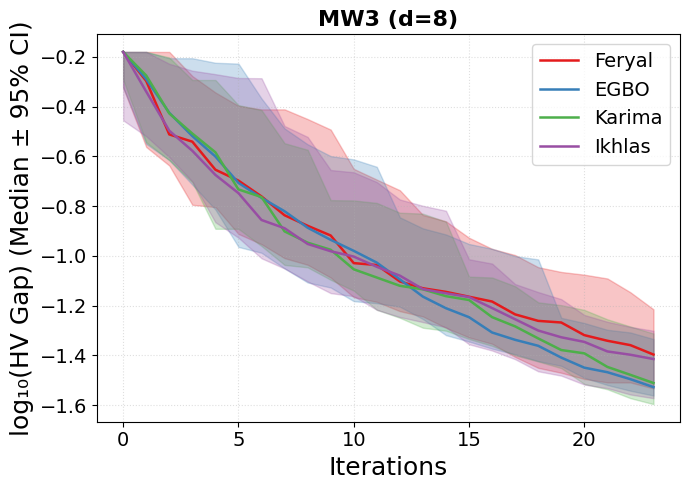

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))
colors = plt.cm.Set1.colors

for (label, gap), c in zip(data_gap.items(), colors):
    median = np.median(gap, axis=0)
    low    = np.percentile(gap, 2.5, axis=0)
    high   = np.percentile(gap, 97.5, axis=0)
    iters  = np.arange(N_BATCHES)

    ax.plot(iters, median, lw=1.8, color=c, label=label)
    ax.fill_between(iters, low, high, color=c, alpha=0.25)

ax.set_title(f"{PROBLEM} (d={N_BATCHES//3})", fontsize=16, weight="bold")
ax.set_xlabel("Iterations")
ax.set_ylabel("log₁₀(HV Gap) (Median ± 95% CI)")
ax.grid(True, ls=":", alpha=0.4)
ax.legend()
fig.tight_layout()

plt.savefig("MW3_regression_CI.png", dpi=300, bbox_inches='tight')
plt.show()



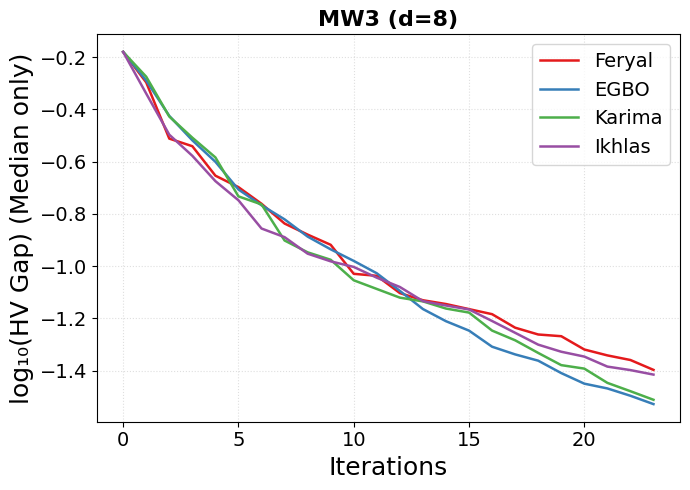

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))
colors = plt.cm.Set1.colors

for (label, gap), c in zip(data_gap.items(), colors):
    median = np.median(gap, axis=0)
    iters  = np.arange(N_BATCHES)

    ax.plot(iters, median, lw=1.8, color=c, label=label)

ax.set_title(f"{PROBLEM} (d={N_BATCHES//3})", fontsize=16, weight="bold")
ax.set_xlabel("Iterations")
ax.set_ylabel("log₁₀(HV Gap) (Median only)")
ax.grid(True, ls=":", alpha=0.4)
ax.legend()
fig.tight_layout()

plt.savefig("MW3_regression.png", dpi=300, bbox_inches='tight')
plt.show()

